In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# A gentle introduction to Gaussian Process Regression

This notebook was made with the following version of george:

In [2]:
import george
george.__version__

'0.3.0'

We'll start by generating some fake data (from a sinusoidal model) with error bars:

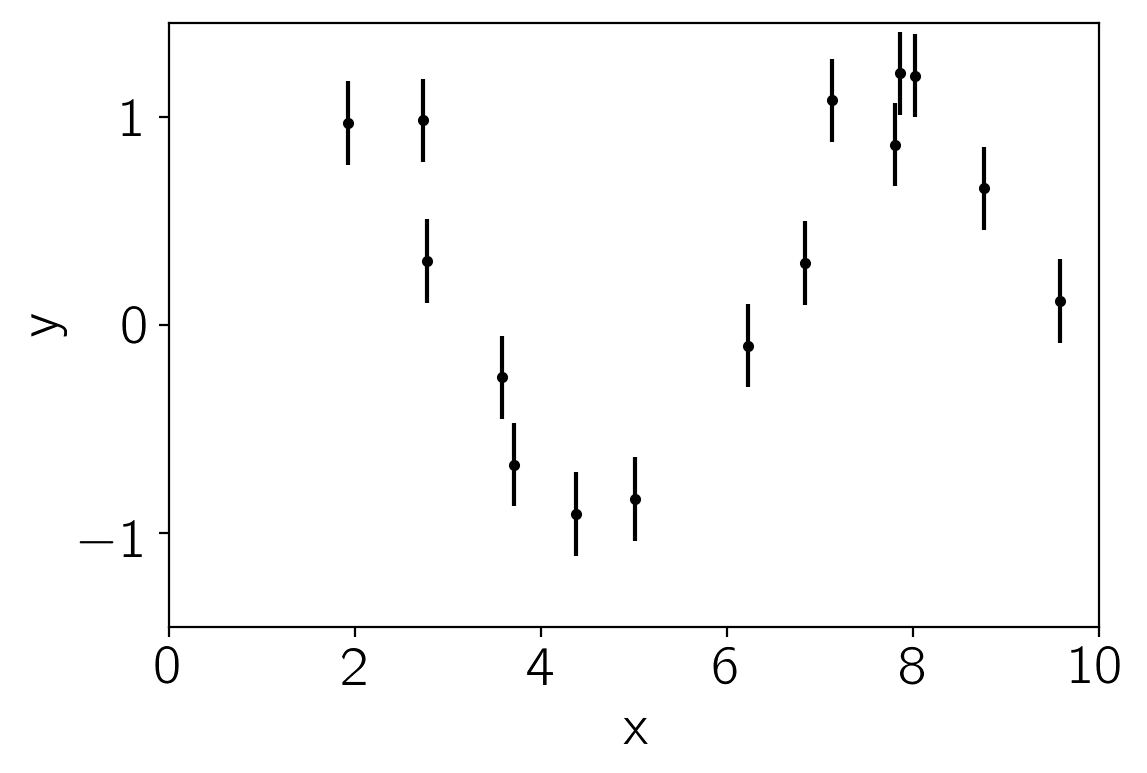

In [3]:
import numpy as np
import matplotlib.pyplot as pl

np.random.seed(1234)
x = 10 * np.sort(np.random.rand(15))
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))

pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.xlim(0, 10)
pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");

Now, we'll choose a kernel (covariance) function to model these data, assume a zero mean model, and predict the function values across the full range. The full kernel specification language is documented [here](../../user/kernels/) but here's an example for this dataset:

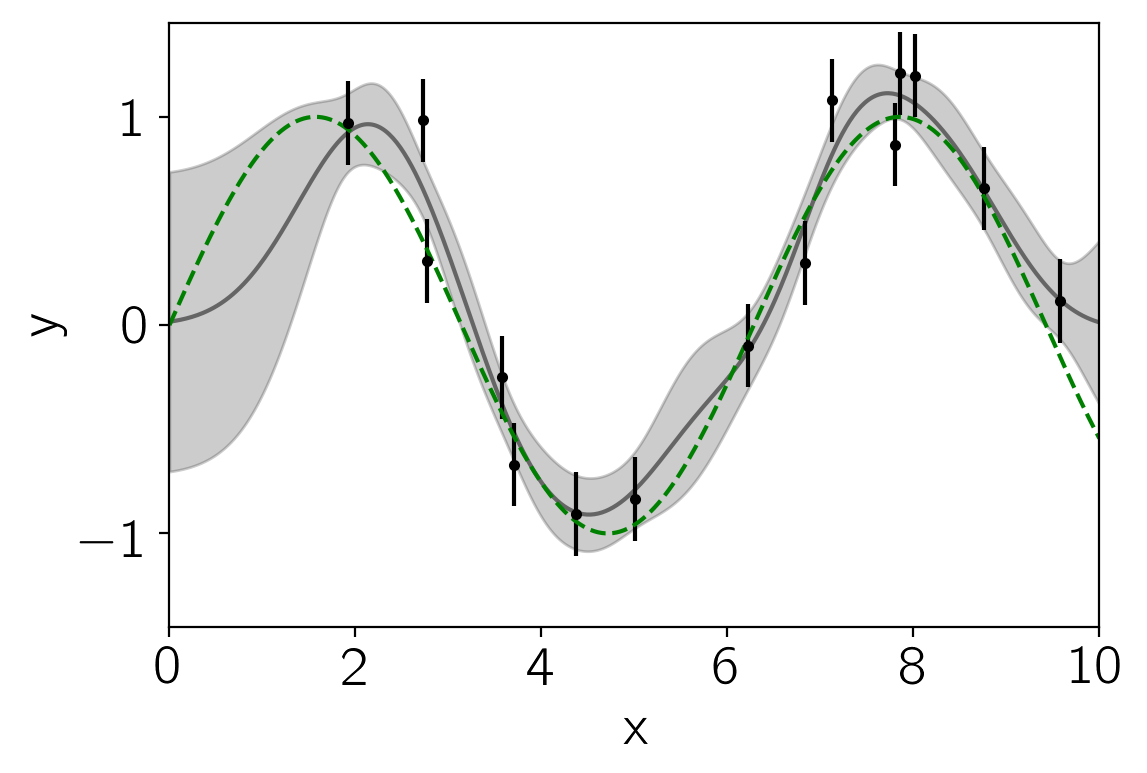

In [4]:
from george import kernels

kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)
gp = george.GP(kernel)
gp.compute(x, yerr)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

pl.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.plot(x_pred, np.sin(x_pred), "--g")
pl.xlim(0, 10)
pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");

The `gp` model provides a handler for computing the marginalized likelihood of the data under this model:

In [5]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -11.82


So we can use this—combined with scipy's [minimize](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function—to fit for the maximum likelihood parameters:

In [6]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: 9.225282556043892
 hess_inv: array([[ 0.52320809,  0.30041273],
       [ 0.30041273,  0.40708074]])
      jac: array([ -5.07047667e-06,   2.56077807e-06])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([-0.48730733,  0.60407551])

Final ln-likelihood: -9.23


And plot the maximum likelihood model:

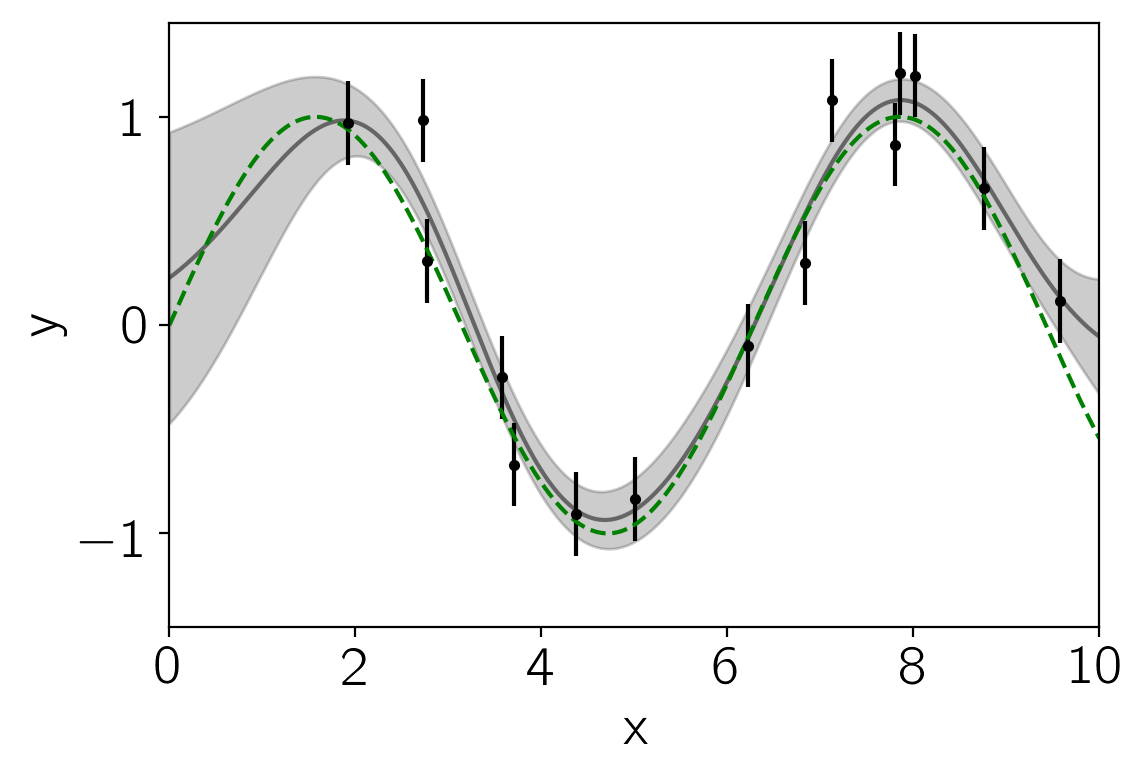

In [7]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)

pl.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.plot(x_pred, np.sin(x_pred), "--g")
pl.xlim(0, 10)
pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");

And there you have it! Read on to see what else you can do with george or just dive right into your own problem.

Finally, don't forget [Rasmussen & Williams](http://www.gaussianprocess.org/gpml/), the reference for everything Gaussian Process.